In [1]:
#start: dereplicated

#export files 

#Euler commands

# skani results

#visualization

In [2]:
import pandas as pd
import qiime2 as q2
%matplotlib inline
from qiime2 import Visualization

data_dir = 'data/processed/05_skANI'

```
mkdir -p /cluster/scratch/$USER/skANI_input

for qza in /cluster/scratch/$USER/03_artifacts/dereplicated_mags/dereplicates*.qza; do
    base=$(basename "${qza}" .qza)
    mosh tools export \
        --input-path "${qza}" \
        --output-path "/cluster/scratch/$USER/skANI_input/${base}"
done
```

```
# skANI for Bacteria MAGs
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_bacteria_dereplicates/* > /cluster/scratch/$USER/skANI_results/bacteria_skani_ani_matrix.txt
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_bacteria_dereplicates/* -E > /cluster/scratch/$USER/skANI_results/bacteria_skani_ani_edge_list.txt
# skANI for Archaea MAGs
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_archaea_dereplicates/* > /cluster/scratch/$USER/skANI_results/archaea_skani_ani_matrix.txt
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_archaea_dereplicates/* -E > /cluster/scratch/$USER/skANI_results/archaea_skani_ani_edge_list.txt
# skANI for Eukaryotes MAGs
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_eukaryota_dereplicates/* > /cluster/scratch/$USER/skANI_results/eukaryotes_skani_ani_matrix.txt
!skani triangle /cluster/scratch/$USER/skANI_input/mags_filtered_eukaryota_dereplicates/* -E > /cluster/scratch/$USER/skANI_results/eukaryotes_skani_ani_edge_list.txt
```

## visualizations
heatmap of the ANI matrixes can be generated to visualize distance


In [3]:
import pandas as pd
import os

file_path = "data/processed/05_skANI/skANI_Results/bacteria_skani_ani_edge_list.txt"

# Read only the relevant columns (first 7: skip any extra trailing columns)
df = pd.read_csv(file_path, sep='\t', usecols=range(7))

# Generate Ref_name and Query_name from filenames
df['Ref_name'] = df['Ref_file'].apply(lambda x: os.path.basename(x).replace('.fasta',''))
df['Query_name'] = df['Query_file'].apply(lambda x: os.path.basename(x).replace('.fasta',''))

print(df.head())


                                            Ref_file  \
0  /cluster/scratch/emotta/skANI_input/mags_filte...   
1  /cluster/scratch/emotta/skANI_input/mags_filte...   
2  /cluster/scratch/emotta/skANI_input/mags_filte...   
3  /cluster/scratch/emotta/skANI_input/mags_filte...   
4  /cluster/scratch/emotta/skANI_input/mags_filte...   

                                          Query_file    ANI  \
0  /cluster/scratch/emotta/skANI_input/mags_filte...  90.85   
1  /cluster/scratch/emotta/skANI_input/mags_filte...  90.85   
2  /cluster/scratch/emotta/skANI_input/mags_filte...  98.96   
3  /cluster/scratch/emotta/skANI_input/mags_filte...  98.76   
4  /cluster/scratch/emotta/skANI_input/mags_filte...  96.35   

   Align_fraction_ref  Align_fraction_query  \
0               57.17                 67.75   
1               61.03                 63.74   
2               31.19                 36.57   
3               88.66                 52.18   
4               82.46                 55.48   

 

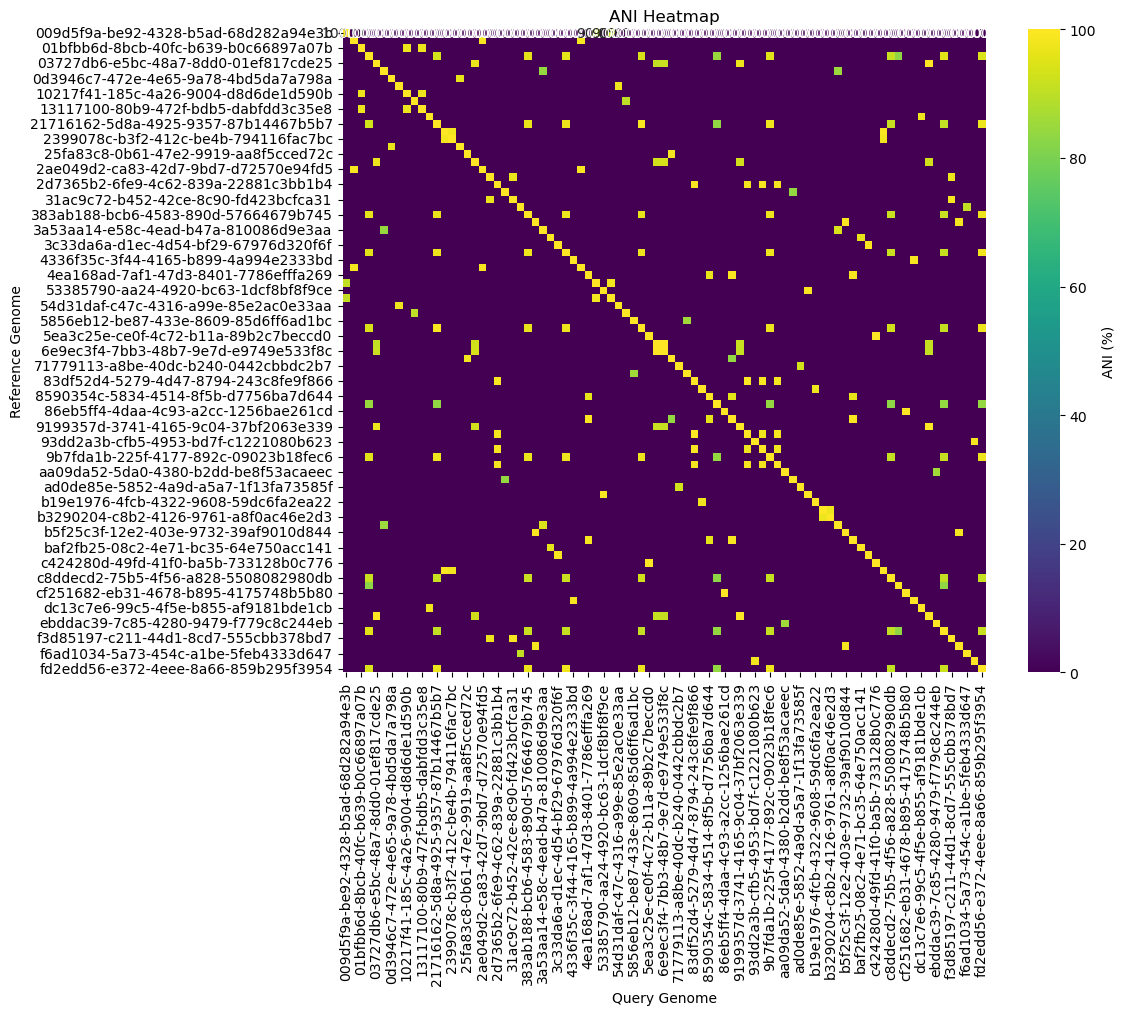

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = df[['Ref_name', 'Query_name', 'ANI']]

# Handle duplicates by averaging ANI values
df = df.groupby(['Ref_name', 'Query_name'], as_index=False)['ANI'].mean()

# Make the matrix symmetric
df_symmetric = pd.concat([
    df,
    df.rename(columns={'Ref_name': 'Query_name', 'Query_name': 'Ref_name'})
])

# Pivot to create heatmap data
heatmap_data = df_symmetric.pivot(index='Ref_name', columns='Query_name', values='ANI')

# Fill missing values with 0
heatmap_data = heatmap_data.fillna(0)
np.fill_diagonal(heatmap_data.values, 100.0)
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'ANI (%)'},
    square=True
)
plt.title('ANI Heatmap')
plt.ylabel('Reference Genome')
plt.xlabel('Query Genome')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


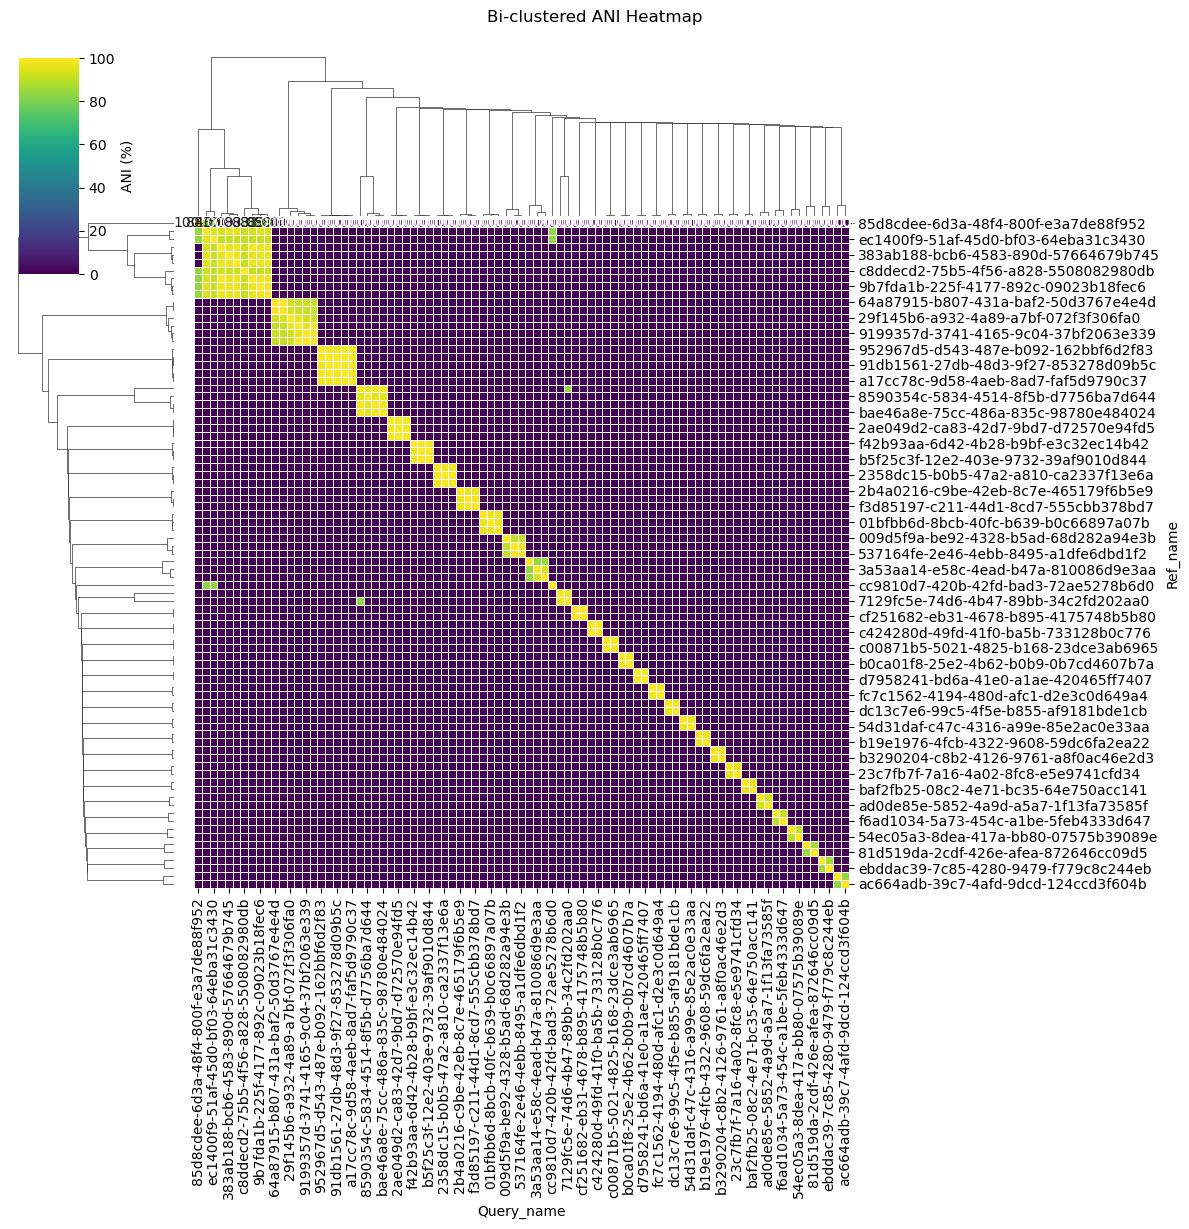

In [11]:
# Keep only necessary columns for heatmap
df = df[['Ref_name', 'Query_name', 'ANI']]

# Handle duplicates by averaging ANI values
df = df.groupby(['Ref_name', 'Query_name'], as_index=False)['ANI'].mean()

# Make the matrix symmetric
df_symmetric = pd.concat([
    df,
    df.rename(columns={'Ref_name': 'Query_name', 'Query_name': 'Ref_name'})
])

# Pivot to create heatmap data
heatmap_data = df_symmetric.pivot(index='Ref_name', columns='Query_name', values='ANI')

# Fill missing values with 0
heatmap_data = heatmap_data.fillna(0)
np.fill_diagonal(heatmap_data.values, 100.0)
# Plot a bi-clustered heatmap
sns.clustermap(
    heatmap_data,
    cmap='viridis',
    linewidths=0.5,
    figsize=(12, 12),
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'ANI (%)'}
)

plt.suptitle('Bi-clustered ANI Heatmap', y=1.02)
plt.show()

In [6]:
import pandas as pd
import numpy as np
import os

file_path = "data/processed/05_skANI/skANI_Results/bacteria_skani_ani_matrix.txt"
n_genomes = 167  # size of the matrix

# Read all lines
with open(file_path) as f:
    lines = [line.strip() for line in f.readlines()]

# Skip the first line (number of genomes)
lines = lines[1:]

# Initialize genome names and the matrix
genomes = []
ani_matrix = np.zeros((n_genomes, n_genomes))

# Fill the lower triangle from file
for i, line in enumerate(lines):
    parts = line.split('\t')
    genome_path = parts[0]
    genomes.append(os.path.basename(genome_path).replace('.fasta',''))
    
    # ANI values for this row
    ani_values = [float(x) for x in parts[1:]]
    
    # Fill lower triangle
    ani_matrix[i, :len(ani_values)] = ani_values

# Create DataFrame
df_heatmap = pd.DataFrame(ani_matrix, index=genomes, columns=genomes)

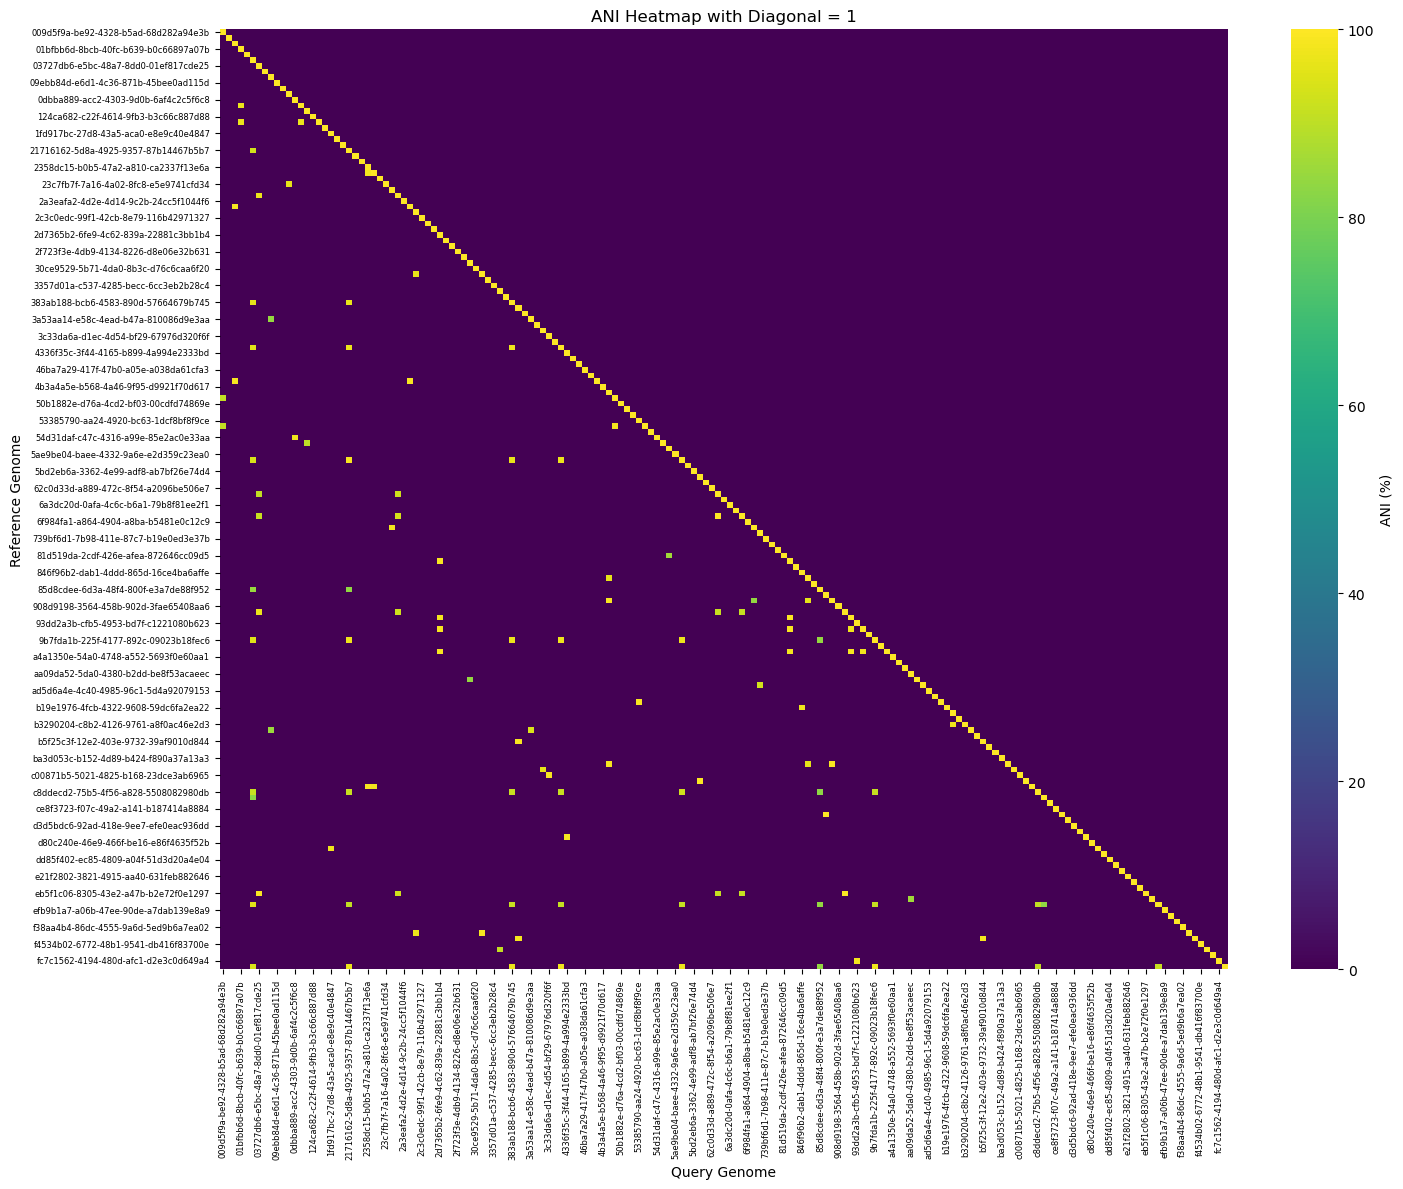

In [7]:
import numpy as np

# Set diagonal to 1
np.fill_diagonal(df_heatmap.values, 100.0)

# Now you can plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(
    df_heatmap,
    cmap='viridis',
    annot=False,
    cbar_kws={'label': 'ANI (%)'}
)
plt.title('ANI Heatmap with Diagonal = 1')
plt.ylabel('Reference Genome')
plt.xlabel('Query Genome')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()


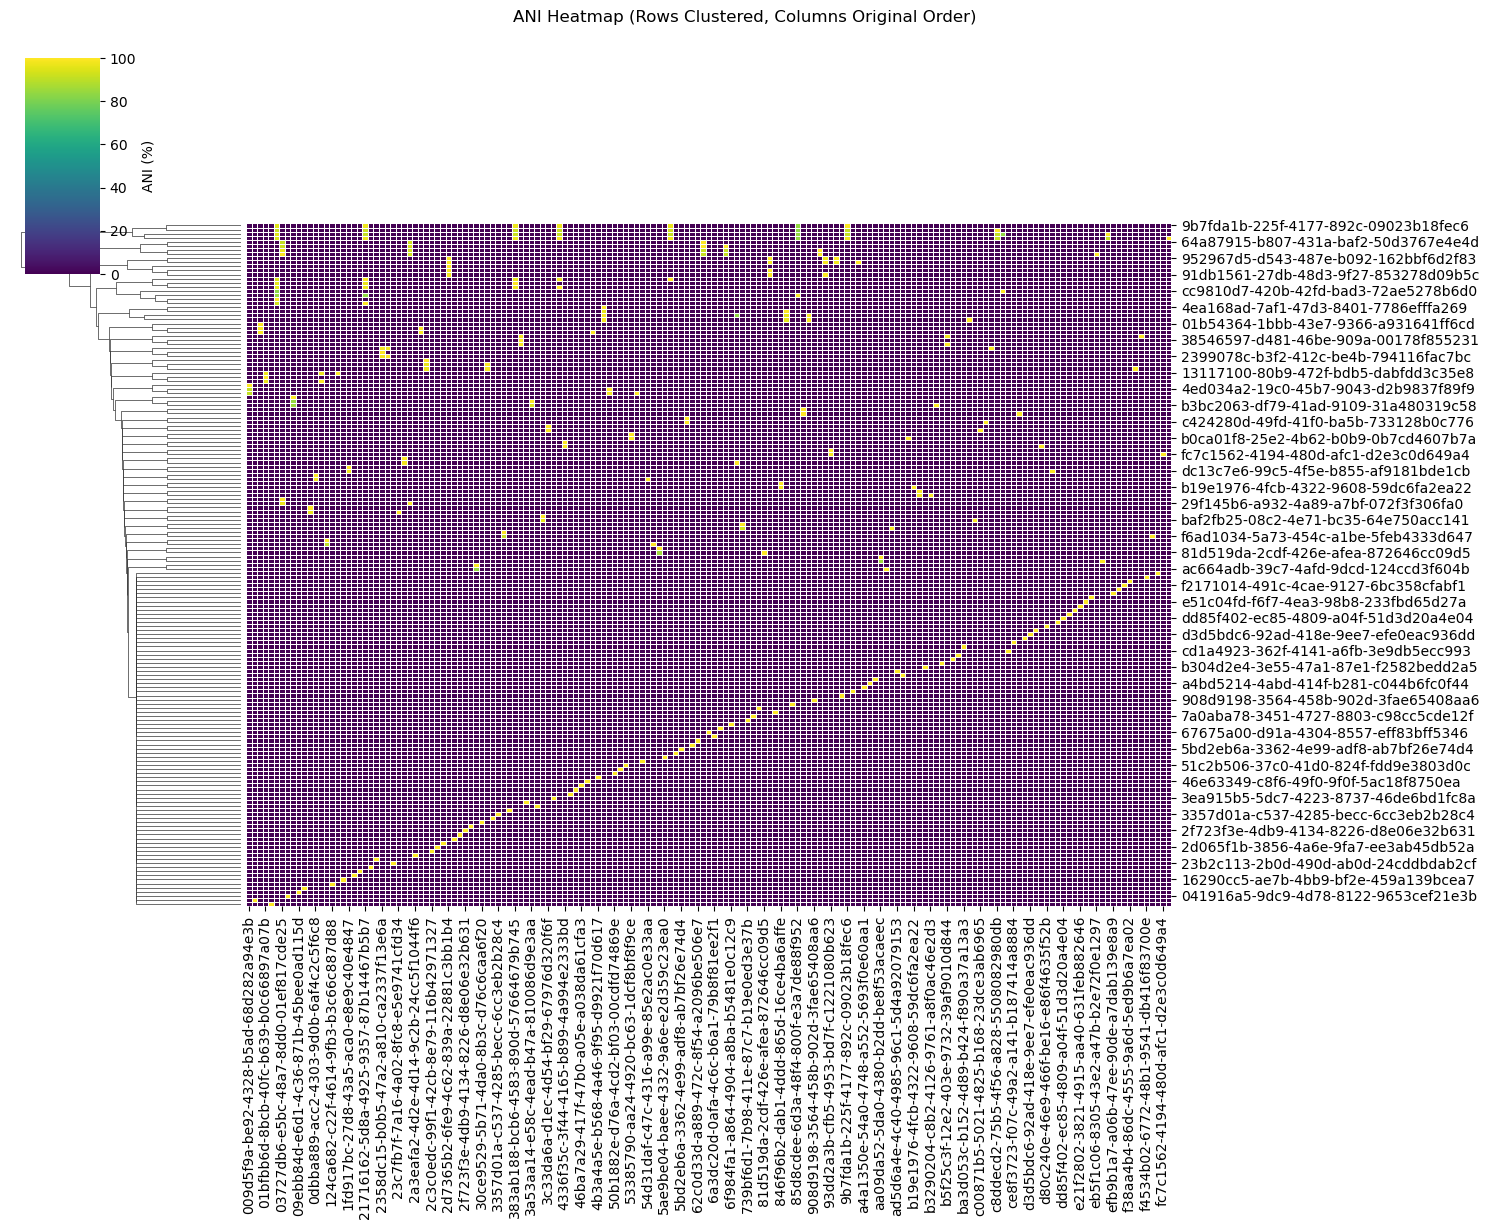

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set diagonal to 1
np.fill_diagonal(df_heatmap.values, 100)

# Bi-clustered heatmap with clustering on rows only
sns.clustermap(
    df_heatmap,
    cmap='viridis',
    linewidths=0.5,
    figsize=(15, 12),
    annot=False,
    cbar_kws={'label': 'ANI (%)'},
    col_cluster=False  # cluster only the rows
)

plt.suptitle('ANI Heatmap (Rows Clustered, Columns Original Order)', y=1.02)
plt.show()
